In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pylab
%matplotlib notebook

## Mutual Information (MI)

Defined as $I(X;Y) = H(X) + H(Y) - H(XY)$, MI is the most general metric of dependence, as $I = 0$ if and only if the observables are truly independent. This is achieved by directly comparing the joint probability distribution to the product of marignal distributions. However, the problem is that the metric requires the joint probability distribution to be fully explored by the data to converge, which is most of the time unrealistic for experimental data. Any estimators of entropy and mutual information for continuous data require assumptions about smoothness of the underlying probability distribution to choose the bin size and discretize the problem. The result is extremely sensitive to bin size, and changes sharply every time a new bin becomes non-zero.


### Statistical preliminaries:
* $H(X) = -\sum_i p_i \log p_i$
  - Entropy: the average number of bits of information obtained from a measurement of X
* $H(X|Y) = H(XY) - H(X)$
  - Conditional Entropy: the information carried by X if Y is already known
* $I(X;Y) = H(X) - H(X|Y) = H(X) + H(Y) - H(XY)$
  - Mutual information: the information carried by both X and Y at the same time
* $I(X;Y|Z) = I(X;YZ) - I(X;Z)$
  - Conditional mutual information: the mutual information between X and Y, given that Z is known

### Empirical estimates

When constructing an empirical estimate for entropy, one runs into the following problems:
* For an arbitrary discrete function, an empirical estimate of the entropy converges only if the number of samples is larger than the size of the support. For an arbitrary continuous function, an empirical estimate will always be wrong.
* Typical solution is to destroy information, discretizing possible variable values to a few bins, and thus reducing the function to a finite support. While it is a valid procedure to compare probability distributions discretized in the same way, the result depends strongly on the size of the bins.

Given the binned empirical probability distribution $\hat{\vec{p}}$, the naive MLE estimate is given by

$\hat{H}_{MLE}(\hat{\vec{p}}) = -\sum_i \hat{p}_i \log \hat{p}_i$

According to <a href="https://kaushikghose.wordpress.com/2013/10/24/computing-mutual-information-and-other-scary-things/">this blog</a>, the naive MLE of entropy has a large bias. It is suggested to use JackKnife bias-corrected estimator instead. It is still biased, but much less, and also less sensitive to bin size

$\hat{H}_{JK}(\hat{\vec{p}}) = N\hat{H}_{MLE}(\hat{\vec{p}})
  - \frac{N-1}{N}\sum_{i=1}^N \hat{H}_{MLE}(\hat{\vec{p}} // \hat{p}_i)
$

where the second term estimates entropy with one less bin for all bins. Further info:
* <a href="https://mitpress.mit.edu/books/spikes">Bialek1997</a> discuss estimating entropy using a prior on smoothness of the underlying distribution. They conclude that the estimator is highly sensitive to smoothness assumptions, which may be hard to obtain for neural data.
* <a href="http://www.cns.nyu.edu/pub/lcv/paninski-infoEst-2003.pdf"> Paninski2003 </a> show that any estimator is strongly biased if $N_{data} \leq N_{bin}$. They also derive an even better approximation called "Best Upper Bounds". It is highly involved though. 
* <a href="https://journals.aps.org/pre/abstract/10.1103/PhysRevE.71.066208">Celucci2005</a> offer another improvement to the algorithm by introducing adaptive binning to best represent the information contained in the data.

**TODO**: Ask Liam for $H_{BUB}$ code

In [23]:
def npExclude(arr, i):
    return np.hstack(arr[:i], arr[i+1:])

def marginal(PXY, axis):
    return np.sum(PXY, axis=axis)

def H_MLE(P):
    P_POS = P[P > 0]
    return np.sum(np.multiply(P_POS, -np.log2(P_POS)))

def HC_XY(PXY, PY):
    return H_MLE(PXY) - H_MLE(PX)

def I_XY(PXY, PX, PY):
    return H_MLE(PX) + H_MLE(PY) - H_MLE(PXY)


def H_X_JK(PX):
    N = len(PX)
    return N*H_X(PX) - (N-1)/N * np.sum([H_X(npExclude(PX, i)) for i in range(N)])

# def IC_XYZ():

### Sanity Check 1:
Compute entropy of a biased coin

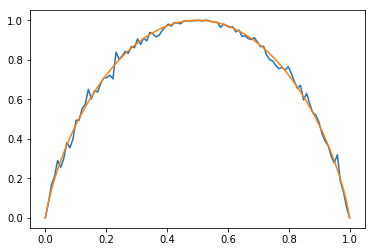

In [18]:
def pdeDiscrete(data):
    binDict = {}
    for d in data:
        if d in binDict.keys():
            binDict[d] += 1
        else:
            binDict[d] = 1
    
    keys = np.array(list(binDict.keys()))
    values = np.array(list(binDict.values()))
    
    return keys, values / len(data)
    
### Sanity Check 1:
nStep = 100
nData = 1000
coinBias = np.linspace(0, 1, nStep)
entropy = np.zeros(nStep)
for i in range(nStep):
    data = (np.random.uniform(0, 1, nData) < coinBias[i]).astype(int)
    pdeDiscrete = binDiscrete(data)[1]
    entropy[i] = H_MLE(pdeDiscrete)
    
plt.figure()
plt.plot(coinBias, entropy)
plt.plot(coinBias, [H_MLE(np.array([p, 1 - p])) for p in coinBias])
plt.show()

### Sanity check 2
Compute mutual information of independent uniform distributions as function of support size

**Conclusion**: As expected, it is effectively zero

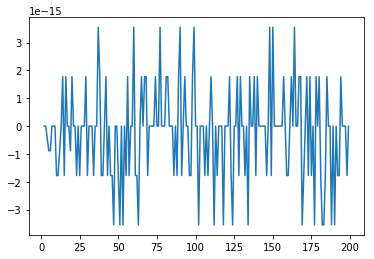

In [31]:
nSize = list(range(2, 200))
entropy = np.zeros(len(nSize))
for i in range(len(nSize)):
    n = nSize[i]
    p_x_empirical = np.random.uniform(0, 1, n)
    p_y_empirical = np.random.uniform(0, 1, n)
    p_x_empirical /= np.sum(p_x_empirical)
    p_y_empirical /= np.sum(p_y_empirical)
    p_xy_empirical = np.outer(p_x_empirical, p_y_empirical)
    entropy[i] = I_XY(p_xy_empirical, p_x_empirical, p_y_empirical)
    
plt.figure()
plt.plot(nSize, entropy)
plt.show()

### Sanity check 3
Check how fast a random discrete MI converges to its true value

**Conclusion**: ??

### Sanity check 4
Continuous data - check how it depends on the size of the bin. Compare fancy estimators.

### Sanity check 5

Simple Harmonic Oscillator - Can it predict that position and velocity completely determine each other?

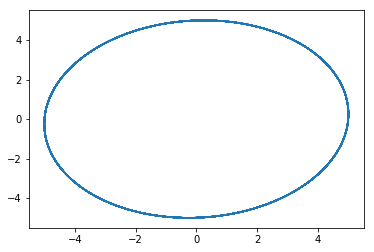

In [38]:
def update(x, v, k, dt):
    vnew = v - k * x * dt
    xnew = x + vnew * dt
    return xnew, vnew

k = 1
dt = 0.1
NT = 1000
xLst = np.zeros(NT)
vLst = np.zeros(NT)
vLst[0] = 5

for i in range(1, NT):
    xLst[i], vLst[i] = update(xLst[i-1], vLst[i-1], k, dt)
    
plt.figure()
plt.plot(xLst, vLst)
# plt.plot(vLst)
plt.show()

In [ ]:
def correlated_x(N, rho=0.5):
    r = np.random.randn(N, 2)
    r1 = r[:,0]
    r1_ = r[:,1]
    r2 = rho*r1 + (1-rho**2)**0.5*r1_
    return r1, r2
 
def bin_data(x,y, bins=11, limits=[-4,4]):
    Nxy, xe, ye = np.histogram2d(x,y,bins=bins,range=[limits,limits])
    N = float(Nxy.sum())
    Pxy = Nxy/N
    Px = Pxy.sum(axis=1)
    Py = Pxy.sum(axis=0)
    return Pxy, Px, Py, N
 
MI_exact = lambda rho: -.5*np.log2(1-rho**2)
 
def H_mle(P):
    idx = pylab.find(P>0)
    return -(P.flat[idx]*np.log2(P.flat[idx])).sum()
 
def MI_mle(x,y, bins=11, limits=[-4,4]):
    Pxy, Px, Py, Ntot = bin_data(x,y,bins=bins,limits=limits)
    return H_mle(Px) + H_mle(Py) - H_mle(Pxy)
 
def MI_mle_jack_knife(x, y, bins=11, limits=[-4,4]):
    Pxy, Px, Py, N = bin_data(x,y,bins=bins,limits=limits)
    Hx = H_mle(Px)
    Hy = H_mle(Py)
    Hxy = H_mle(Pxy)
    Hx_jk = 0
    Hy_jk = 0
    Hxy_jk = 0
    for n in range(x.size):
        jx = np.concatenate((x[:n],x[n+1:]))
        jy = np.concatenate((y[:n],y[n+1:]))
        Pxy, Px, Py, Njk = bin_data(jx,jy,bins=bins,limits=limits)
        Hx_jk += H_mle(Px)
        Hy_jk += H_mle(Py)
        Hxy_jk += H_mle(Pxy)
 
    Hx_jk = N*Hx - (N-1.0)/N*Hx_jk
    Hy_jk = N*Hy - (N-1.0)/N*Hy_jk
    Hxy_jk = N*Hxy - (N-1.0)/N*Hxy_jk
 
    return Hx_jk + Hy_jk - Hxy_jk
 
def runmany(func, N=50, rho=0, bins=11, limits=[-4,4], b=1000):
    mi = np.empty(b)
    for n in range(b):
        r1,r2 = correlated_x(N, rho)
        mi[n] = func(r1,r2,bins=bins)
    mi.sort()
    med_idx = int(b*0.5)
    lo_idx = int(b*0.025)
    hi_idx = int(b*0.975)
    return mi[lo_idx], mi[med_idx], mi[hi_idx]
 
b = 1000
Ni = 20
rho = np.linspace(0,.99,Ni)
mi_exact = MI_exact(rho)
N = 100
cols = [(.5,.5,.5), (.7,.7,.7)]
for lab, func in zip(['MI MLE', 'MI Jack Knife'], [MI_mle, MI_mle_jack_knife]):
    plt.figure(figsize=(10,5))
    for k, bins in enumerate([11,21]):
        mi_est = np.empty((Ni,3))
        for n in range(rho.size):
            #mi_est[n,:] = runmany(MI_mle_jack_knife, N=N, rho=rho[n], bins=bins, limits=[-4,4], b=b)
            #mi_est[n,:] = runmany(MI_mle, N=N, rho=rho[n], bins=bins, limits=[-4,4], b=b)
            mi_est[n,:] = runmany(func, N=N, rho=rho[n], bins=bins, limits=[-4,4], b=b)
        plt.fill_between(rho, mi_est[:,0], mi_est[:,2],color=cols[k],edgecolor='k',alpha=.5)
        plt.plot(rho, mi_est[:,1], 'k', lw=2)
        plt.plot(rho, mi_exact, 'b',lw=2)
        plt.xlabel(r'$\rho$')
        plt.ylabel(lab)

In [ ]:
# Introduction into phase-space metrics
# Below code demonstrates that entropy is related to the area of the support
NDATA = 500
NBINS = 100

data = np.random.randint(0, NBINS, NDATA)
bins = np.zeros(NBINS)
nzero = np.zeros(NDATA)
entropy = np.zeros(NDATA)

for i in range(NDATA):
    bins[data[i]] += 1
    nzero[i] = np.count_nonzero(bins)
    distr = bins / (i+1)
    entropy[i] = H_X(np.array([(0, p) for p in distr]))
    
def exp_ndata(n, nbin):
    return 1 - (1 - 1/nbin)**n
    
expected = exp_ndata(np.linspace(1, NDATA+1, NDATA), NBINS)
    
plt.figure()
plt.plot(entropy / np.log2(NBINS), label='entropy')
plt.plot(expected, label='area-ratio-analytic')
plt.plot(nzero / NBINS, label='area-ratio-real')
plt.legend()
plt.show()